# Tutoriel de la classe MarthePump

**Ce notebook donne un bref aperçu du fonctionnement et de l'utilisation de la classe MarthePump.**
L'ajout de ces fonctionnalités a nécessité de nouvelle dépendences à la librairie principale PyMarthe:
1. re  *(regular expression, utile pour manipuler du texte)*
2. ast *(abstract syntax trees, utile pour convertir du texte en nombres (int, float)*

## Description

La classe MarthPump permet de **lire, stocker, modifier et écrire** les débits de pompage affectés à une cellule (maille). **Attention, elle ne permet pas d'en rajouter ou d'en retirer des nouveaux!**

## Insertion dans Pymarthe

La lecture d'un modèle Marthe avec PyMarthe reste quasiment inchangée. Seul 2 attributs sont systématiquement  ajoutés à l'instance de classe  MartheModel lors du chargement d'un modèle Marthe existant:
1. `nstep` le nombre total de pas de temps (y compris le régime permanent initial)
2. `mpump` la classe MarthePump vide (None)

In [3]:
# ---- Import packages
import os, sys
from zipfile import ZipFile
import numpy as np
import pandas as pd
from shutil import which, copy2
import subprocess as sp
import time

# ---- Import PyMarthe librairy
sys.path.append(os.path.normpath('..','..'))
from pymarthe import MartheModel

In [2]:
# ---- Unzip compress model
mpath = 'hallue_verif'
with ZipFile(f'{mpath}.zip', 'r') as z:
    z.extractall()

for f in os.listdir(mpath):
    src = os.path.join(mpath,f)
    dst = os.getcwd()
    copy2(src,dst)

# ---- Load model
mm = MartheModel('hallue.rma')

# ---- Print new attributs
print(f'Number of timesteps: {mm.nstep}')
print(f'Pumping object: {mm.mpump}')

Number of timesteps: 6211
Pumping object: None


## Ajout des pompages

Si l'on souhaite travailler sur les pompages, alors il est nécessaire d'ajouter une classe MarthePump dans l'attribut `mm.mpump`. Pour cela il suffit d'ajouter la lecture des pompages grâce à la fonction `.add_pump()`. Cette fontion prend en argument (optionnel) le fichier pas de temps de marthe *(.pastp)*. Si aucun fichier pas de temps n'est ajouté en argument, alors le fichier pas de temps recherché sera `nom_du_modele.pastp`.

In [3]:
# ---- Add pumping
mm.add_pump('hallue_maj.pastp')

print(mm.mpump)

## Lecture des données de pompage

La classe MarthePump permet de lire 3 formats de conditions de pompage différents qui peuvent coexister: 
1. `mail` : (maille) condition de pompage appliquée pour une maille pour un pas de temps donné. Ce format est défini dans le fichier pas de temps par la localisation de la cellule *(`c, l, p` pour colonne, ligne, plan)* et la valeur du prélèvement *(`v`)* 
2. `record` : (chronique) condition de pompage appliquée pour une maille pour plusieurs pas de temps. Ce format est défini dans le fichier pas de temps par la localisation de la cellule *(`c, l, p` pour colonne, ligne, plan)*, la valeur du prélèvement au premier pas de temps (permanent) *(`v`)* et pointe vers un fichier texte externe en précisant le numéro de la colonne correspondante aux valeurs pour tous les pas de temps transitoires *(`File, Col`)*. Le fichier externe en question est défini par un séparateur de type tabulation *(`\t`)*. La première ligne du fichier est constituée par des *headers* c'est à dire le nom de la cellule *(`Xc_Yl`)* : par exemple, si une chroniques de pompage est appliquée à la cellule/maille colonne 18 et ligne 56, le titre de la colonne du fichier externe sera *X18_Y56*.
3. `listm` : (liste de maille) condition de pompage appliquée pour plusieurs mailles pour un pas de temps donné. Ce format est défini dans le fichier pas de temps par le chemin vers un fichier externe possédant les donnée de pompage *(`N:`)*. Le fichier externe en question est un fichier texte sans *headers* constitué de 4 colonnes séparées par des tabulations *(`\t`)*. Dans la première colonne est stockée la valeur du prélèvement *(`v`)* et dans les 3 autres la localisation de la maille/cellule *(`c, l, p` pour colonne, ligne, plan)*.

Les données de pompages sont stockées dans l'attribut `.pumping_data` sous forme d'un large dictionnaire possédant comme clés les pas de temps *(`istep`)* et en valeur un `ndarray` structuré où chaque élément est défini par `(v,c,l,p)` (valeur, colonne, ligne, plan).

In [4]:
# ---- Print all data
print(mm.mpump.pumping_data)

{0: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 1: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 2: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 3: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 4: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 5: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 6: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 7: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'), ('C', '<i4'), ('L', '<i4'), ('P', '<i4')]), 8: array([(0., 18, 33, 1), (0., 20, 42, 1)],
      dtype=[('V', '<f8'),

Pour extraire des données de pompages il suffit d'utiliser la méthode `.get_data()`. Il est possible de préciser le pas  de temps pour lequel on souhaite extraire les données *(`ndarray`)* sinon, par défaut, la fonction renvoie toutes les données *(`dict`)*

In [5]:
# ---- Extract all pumping data
alldata = mm.mpump.get_data()
print(type(alldata))

# ---- Extract data for timestep n°9
arr9 = mm.mpump.get_data(istep = 9)
print(type(arr9))

<class 'dict'>
<class 'numpy.ndarray'>


## Lecture des noms des fichiers externes

De la même manière il est possible d'extraire les noms des fichiers de pompages externes où sont stockés les données. Pour cela il faut utiliser la méthode `.get_qfilenames()`.

In [6]:
# ---- Extract all pumping filenames
qfilenames = mm.mpump.get_qfilenames()
print(type(qfilenames))

# ---- Extract data for timestep n°9
arr9 = mm.mpump.get_qfilenames(istep = 9)
print(type(arr9))

<class 'dict'>
<class 'numpy.ndarray'>


Les noms des fichiers sont constitués par le chemin d'accès au fichier suivi d'un **tag** correspondant à la la colonne contenant la valeur de pompage dans le fichier. Le chemin et le tag sont séparés par un symbole **&**

In [7]:
# ---- View of qfilename for timestep n°9
fpath, tag = arr9[0].split('&')

print(f'Qfilename : {arr9[0]}')
print(f'Full path : {fpath}')
print(f'Tag : {tag}')

Qfilename : prelevements_souterrains.txt&RecordCol=0RecordLin=9
Full path : prelevements_souterrains.txt
Tag : RecordCol=0RecordLin=9


## Extraction des pompages par types de format

Par ailleurs, il est tout à fait possible d'extraire les données de pompage en fonction du format dont les données ont été implémentées : `mail`, `record` ou `listm`. Pour réaliser cela, il faut utiliser la fonction `.split_qtype()`. Cette fonction renvoie un DataFrame avec les informations suivantes:
1. `qtype` : type de format du pompage
2. `istep` : n° du pas de temps (istep=0 pour le permanent initial)
3. `qfilename` : chemin vers le fichier externe où est stockée la donnée de pompage
4. `i` : ligne à laquelle la donnée de pompage est stockée dans le fichier externe
5. `j` : colonne à laquelle la donnée de pompage est stockée dans le fichier externe
6. `v` : valeur du prélèvement
7. `c` : n° colonne de la cellule/maille dans laquelle le pompage est appliqué
8. `l` : n° ligne de la cellule/maille dans laquelle le pompage est appliqué
9. `p` : n° plan (couche) de la cellule/maille dans laquelle le pompage est appliqué 

In [8]:
# ---- Extract pumping data by qtype
record_df = mm.mpump.split_qtype('record')
record_df.head(4)

,qtype,istep,qfilename,i,j,v,c,l,p
2,Record,1,prelevements_souterrains.txt,1.0,0.0,0.0,18,33,1
3,Record,1,prelevements_souterrains.txt,1.0,1.0,0.0,20,42,1
4,Record,2,prelevements_souterrains.txt,2.0,0.0,0.0,18,33,1
5,Record,2,prelevements_souterrains.txt,2.0,1.0,0.0,20,42,1


Note:
- Si aucun types de donnée n'est renseigné dans la fonction `.split_qtype()`, la fonction renvoie les 3 Dataframes
- Si la donnée n'est pas stockée dans un fichier externe, `qfilename`, `i` et `j` sont égaux à `None`/`NaN`
- Si le modèle n'utilise pas ce type de format, la fonction renvoie un DataFrame vide

In [9]:
# ---- Extract pumping data for all qtypes
mail_df, record_df, listm_df = mm.mpump.split_qtype()


# ---- Display mail and listm Dataframes inline
from IPython.display import display_html
captions = ['DataFrame Mail format :', 'DataFrame Listm format :']
dfs = []
for df, caption in zip([mail_df, listm_df], captions ):
    style = df.style.set_table_attributes("style='display:inline'")
    style_caption = style.set_caption(caption)
    html = style._repr_html_()
    dfs.append(html)
mail, listm = dfs
display_html(mail + "\xa0\xa0\xa0"*15 + listm, raw=True)

,qtype,istep,qfilename,i,j,v,c,l,p
0,Mail,0,None,nan,nan,0.000000,18,33,1
1,Mail,0,None,nan,nan,0.000000,20,42,1
,qtype,istep,qfilename,i,j,v,c,l,p


## Modifications des prélèvements

Si l'on désire réaliser des changements sur les valeurs des prélèvements, il est largement recommandé d'utiliser la fonction `.set_data()`. Polyvalente, elle permet de modifier au choix:
- toutes les valeurs de prélèvement pour tous les pas de temps
- toutes les valeurs de prélèvement pour un pas de temps donné
- la valeur du prélèvement d'une cellule pour tous les pas de temps
- la valeur du prélèvement d'une cellule pour un pas de temps donné

In [10]:
# ---- Modify all pumping data for all time steps
mm.mpump.set_data(pdata = mm.mpump.get_data())

# ---- Modify all pumping data for a given timestep
mm.mpump.set_data(istep = 5, arr = mm.mpump.get_data(5))

# ---- Modify cell pumping data for all timesteps
mm.mpump.set_data(c = 20, l = 42, p = 1, v = -850.)

# ---- Modify cell pumping data for a given timesteps
mm.mpump.set_data(istep = 0, c = 20, l = 42, p = 1, v = -950.)

Note : la fonction `.set_data()` permet une modification *inplace* des valeurs de prélèvement. Cela signifie que les changements sont enregistrés dans l'attribut `pumping_data` de la classe MarthePump. Pour confirmer les changements réaliser (notamment avant de (re)lancer un modèle) il est nécessaire d'écrire les modifications `.write_data()` dans le fichier pas de temps *(`.pastp`)* et/ou les possibles autres fichiers externes.

## Exemple d'application

Il est présenté ci-dessous un exemple d'application de manipulation des données de pompage avec PyMarthe et la classe MarthePump. L'objectif est de charger un modèle marthe *('hallue.rma')*, extraire et modifier les prélèvements d'un puits et enfin de relancer le modèle. L'avantage de PyMarthe réside dans la possibilité de réaliser plusieurs éxecutions de modèle consécutives pour des valeurs de prélèvements (itérations). 

#### Application: Modifier le prélèvement du puits de production X18_Y33

Pour commencer, on défini une fonction permettant de récupérer rapidement les valeurs de rabattements du puits dans le fichier simulé `historiq.prn`.

In [11]:
# ---- Extract sim values by column number
def extract_prn_by_col(prn_file, icol, name ):
    df = pd.read_csv(prn_file, sep='\t', usecols = [icol], skiprows = 3)
    df.columns = [name]
    return df

Chargement et éxécution du modèle initial.

In [12]:
# ---- Set names
rma_name = 'hallue.rma'
prn_file = 'historiq.prn'
exe = 'Marth_R8'

# ---- Load marthe model
mm = MartheModel(rma_name)

# ---- Add pumping
mm.add_pump('hallue_maj.pastp')

# ---- Run initial model
mm.run_model(exe_name='Marth_R8')

# ---- Extract drawdown at X18_Y33
results = [extract_prn_by_col(prn_file, icol = 16, name = 'Initial')]

L'objectif est de réaliser des changements de prélèvements en fonction de la saisonnalité. On desire simuler des prélèvements (dans le puits X18_Y33) à hauteur de **50 m<sup>3</sup>/h** lors des mois hivernaux (de mai à octobre) et par la suite, de simuler des scénarios sur les données historiques avec un pompage pour les mois estivaux (de novembre à avril) correspondant à :
- **80 m<sup>3</sup>/h** *(scénario 1)*
- **110 m<sup>3</sup>/h** *(scénario 2)*

In [13]:
# ---- Create timeseries
start = '31/07/1995'
end = '31/07/2012'
dates = pd.date_range(start, end, freq = 'D')

# ---- Build DataFrame
seasons = ['winter' if date.month in [1,2,3,4,11,12] else 'summer' for date in dates]
sc_df = pd.DataFrame({'season':seasons}, index = dates)

# ---- Add pumping values according to scenario
pwinter, psc1, psc2 = [(x * 1.157e5) / 3600 for x in [50,80,110]]
sc_df['sc1'] = sc_df['season'].apply(lambda r : psc1 if r == 'summer' else pwinter)
sc_df['sc2'] = sc_df['season'].apply(lambda r : psc2 if r == 'summer' else pwinter)

sc_df.head()

,season,sc1,sc2
1995-07-31,summer,2571.111111,3535.277778
1995-08-01,summer,2571.111111,3535.277778
1995-08-02,summer,2571.111111,3535.277778
1995-08-03,summer,2571.111111,3535.277778
1995-08-04,summer,2571.111111,3535.277778


In [14]:
# ---- Create a loop to modify data, run model and extract drawdown data
for sc in ['sc1', 'sc2']:
    # -- Modify data
    for istep, val in enumerate(sc_df[sc]):
        mm.mpump.set_data(istep=istep, c=18, l=33, p=1, v=val)
    # -- Write data
    mm.mpump.write_data()
    # -- Run model
    mm.run_model(exe_name='Marth_R8')
    # -- Extract drawdown
    res = extract_prn_by_col(prn_file, icol = 16, name = sc)
    results.append(res)

Maintenant observons les chroniques de rabattement au puits X18_Y33 des différents scénarios.

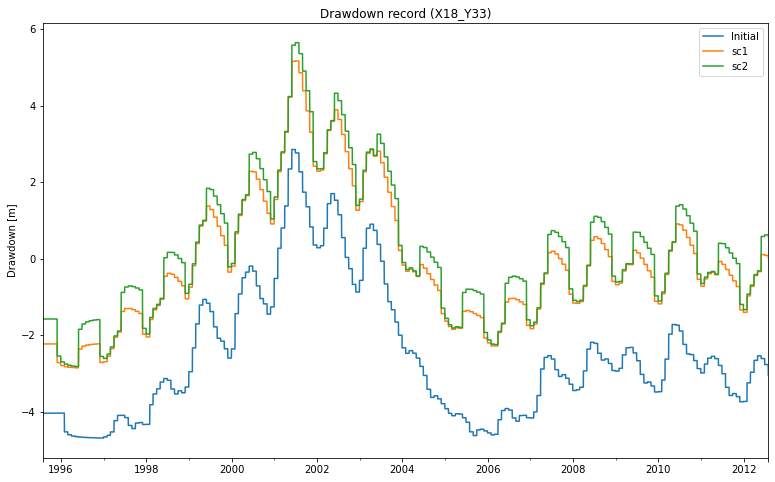

In [15]:
# ---- Concatenate results
df = pd.concat(results , axis=1)
df.set_index(dates, inplace = True)

# ---- Plot drawdown
df.plot(title = 'Drawdown record (X18_Y33)',
        xlabel = '',
        ylabel = 'Drawdown [m]',
        figsize = (13,8))